In [2]:
import requests
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy
import re
import time
import json
import os
import glob
import datetime
import tqdm

In [3]:
def timestamp_to_iso(ts):
    return datetime.datetime.isoformat(datetime.datetime.fromtimestamp(ts))

In [4]:

oldest_timestamp = int(datetime.datetime.timestamp(datetime.datetime(year=2016, month=1, day=1)))
newest_timestamp = int(time.time())

per_iteration = 1000

data_dir = os.path.join(os.getcwd(), "raw_data")
os.makedirs(data_dir, exist_ok=True)

def get_data_in_timestamp_range(start_time, end_time, data_dir, per_iteration):
    print(f"Start date: {timestamp_to_iso(oldest_timestamp)} End Date: {timestamp_to_iso(end_time)}")
    #print(f"Start_time: {start_time} End_time: {end_time} Duration: {end_time - start_time}")
    retry_count = 0
    iter_start_timestamp = start_time
    while iter_start_timestamp < end_time:
        print(f"\rCurrent start date: {timestamp_to_iso(iter_start_timestamp)}", end="")
        if retry_count > 10:
            print(f"\n\n\tHit limit of {retry_count}, exiting!")
            break
        
        # 0.5 causes no rate limiting
        time.sleep(0.3)
        url = f"https://api.pushshift.io/reddit/search/submission/?subreddit=hardwareswap&sort=asc&sort_type=created_utc&after={iter_start_timestamp}&before={end_time}&size={per_iteration}"
        response = requests.get(url)
        
        if response.status_code == 429: #if rate limited, then sleep for a little bit
            print(f"Rate limited, sleeping for 10 seconds")
            retry_count += 1
            time.sleep(10)
            continue
        elif response.status_code == 521: # cloudflare says server is down
            print(f"\nGot 521 status code, sleeping 10 seconds and trying again")
            retry_count += 1
            time.sleep(10)
            continue
        elif response.status_code>500:
            print(f"\nUnknown Status Code: {response.status_code}. Sleeping for 10 seconds and trying again\nContent: {response.content}\nurl: {url}")
            retry_count += 1
            time.sleep(10)
            continue
        elif response.status_code > 201:
            raise ValueError(f"\nbad response from server for: Status Code: {response.status_code}\nContent: {response.content}\nurl: {url}")
        
        retry_count  = 0 # made it this far so not retrying
        data = response.json()['data']
        if len(data) == 0:
            print(f"\n\tDone! len(data) == 0")
            break

        time_file_start = data[0]['created_utc']
        time_file_end = data[-1]['created_utc']

        if iter_start_timestamp == time_file_end:
            print(f"\n\tDone! iter_start_timestamp == time_file_end")
            break

        fname =  f"data_{time_file_start}-{time_file_end}.json"
        with open(os.path.join(data_dir, fname), 'w') as fp:
            json.dump(data, fp)
        iter_start_timestamp = time_file_end

def find_existing_time_range_on_disk(data_dir):
    """
    Return the start and end time for all data on disk
    """
    start_time = int(time.time())
    end_time = 0
    file_count = 0
    for fname in glob.glob(os.path.join(data_dir, "data_*-*.json")):
        file_count += 1
        start, end = os.path.splitext(os.path.basename(fname))[0].split("_")[1].split("-")
        start_time = min(start_time, int(start))
        end_time = max(end_time, int(end))
    return start_time, end_time

def load_data_from_disk(data_glob_pattern):
    all_data = []
    for fname in glob.glob(data_glob_pattern):
        with open(fname, 'r') as fp:
            data = json.load(fp)
        all_data.extend(data)
    df = pd.DataFrame(all_data)
    df.sort_values("created_utc", inplace=True)
    df.reset_index(inplace=True, drop=True)
    return df



In [4]:
existing_start, existing_end = find_existing_time_range_on_disk(data_dir)
if existing_start > oldest_timestamp:
    print(f"Need to find older data. Oldest data on disk is {existing_start}, but want data starting at {oldest_timestamp}")
    get_data_in_timestamp_range(oldest_timestamp, min(existing_start,newest_timestamp),  data_dir, per_iteration)
    
existing_start, existing_end = find_existing_time_range_on_disk(data_dir)
if existing_end < newest_timestamp:
    print(f"Need to find newer data. Newest data on disk is {existing_end}, but want data ending at {newest_timestamp}")
    get_data_in_timestamp_range(max(existing_end,oldest_timestamp), newest_timestamp, data_dir, per_iteration)



Need to find older data. Oldest data on disk is 1451628003, but want data starting at 1451628000
Start date: 2016-01-01T00:00:00 End Date: 2016-01-01T00:00:03
Current start date: 2016-01-01T00:00:00
	Done! len(data) == 0
Need to find newer data. Newest data on disk is 1633374666, but want data ending at 1634261716
Start date: 2016-01-01T00:00:00 End Date: 2021-10-14T20:35:16
Current start date: 2021-10-08T13:23:29Rate limited, sleeping for 10 seconds
Current start date: 2021-10-12T15:17:23Rate limited, sleeping for 10 seconds
Current start date: 2021-10-14T20:32:32
	Done! len(data) == 0


In [5]:
df = load_data_from_disk(os.path.join(data_dir, "data_*-*.json"))
print(f"Have {len(df)} items")

Have 671336 items


In [51]:
for col in df.columns:
    print(f"{col} {type(df.at[13, col])}")

all_awardings <class 'float'>
allow_live_comments <class 'float'>
author <class 'str'>
author_flair_background_color <class 'float'>
author_flair_css_class <class 'str'>
author_flair_richtext <class 'float'>
author_flair_text <class 'str'>
author_flair_text_color <class 'float'>
author_flair_type <class 'float'>
author_fullname <class 'str'>
author_patreon_flair <class 'float'>
author_premium <class 'float'>
awarders <class 'float'>
can_mod_post <class 'float'>
contest_mode <class 'float'>
created_utc <class 'numpy.int64'>
domain <class 'str'>
full_link <class 'str'>
gildings <class 'float'>
id <class 'str'>
is_created_from_ads_ui <class 'float'>
is_crosspostable <class 'float'>
is_meta <class 'float'>
is_original_content <class 'float'>
is_reddit_media_domain <class 'float'>
is_robot_indexable <class 'float'>
is_self <class 'numpy.bool_'>
is_video <class 'float'>
link_flair_background_color <class 'float'>
link_flair_css_class <class 'str'>
link_flair_richtext <class 'float'>
link_fla

In [47]:
len(df[ (df["selftext"]=="[deleted]") | (df["selftext"]=="[removed]")])

110820

In [5]:
class TitleParseException(Exception):
    def __init__(self, title, msg=""):
        self.title = title
        self.message = f"{msg} Failed to parse title {title}"
        super().__init__(self, self.message)

        
class UnknownTransactionTypeException(Exception):
    def __init__(self, have, want):
        self.have = have
        self.want = want
        self.message = f"Unknown transaction type for have {self.have} and want {self.want}"
        super().__init__(self, self.message)
        
        
def parse_title(title):
    """
    Given the title text return parsed information
    """
    if "[H]" not in title:
        raise TitleParseException(title=title, msg="[H] not in title")
    if "[W]" not in title:
        raise TitleParseException(title=title, msg="[W] not in title")
    location_raw, remainder = title.split("[H]")
    have_raw, want_raw = remainder.split("[W]")

    location = location_raw.replace("]","").replace("[","").strip()

    return {"location":location, "have": have_raw, "want": want_raw}
def get_transaction_type(have, want):
    """
    Return the transaction type
    """
    transaction_type = None
    have = have.lower()
    want = want.lower()
    
    if ("paypal" not in have) and ("cash" not in have) and ("paypal" not in want) and ("cash" not in want):
        raise UnknownTransactionTypeException(have, want)
        
    if "paypal" in have:
        transaction_type = "buy"
    elif "cash" in have:
        transaction_type = "buy"
    
    if "paypal" in want:
        transaction_type = "sell"
    elif "cash" in want:
        transaction_type = "sell"
    
    return transaction_type
  
def identify_if_gpu(data):
    """
    Given a string for 
    """
    data = data.lower()
    gpu_mfgs = ["evga", "msi", "asus", "gigabyte", "zotac" ]
    gpu_skus = ["3090", "3080", "3070", "3060", "2080", "2070", "2060", "1080", "1070","1060", "1050", "1030", "1650", "980", "970", "960"]
    exclude_values = ["1080p", "intel", "10700", "11700", "laptop", "complete computer", "full pc", "pc build"]
    
    manufacturers = []
    for mfg in gpu_mfgs:
        if mfg in data:
            manufacturers.append(mfg)
    skus = []
    for sku in gpu_skus:
        if sku in data:
            skus.append(sku)
    exclude = []
    for item in exclude_values:
        if item in data:
            exclude.append(item)
            
    
    return manufacturers, skus, exclude


def get_prices(text):
    """
    Get all prices in the text
    """
    text = text.lower()
    no_spaces = text.replace("","")
    
    price_matcher = re.compile(r'[$]\d+,?\d*')
    prices = price_matcher.findall(no_spaces)
    return prices

idx = 4
title = df.at[idx,"title"]
print(title)
parsed_title = parse_title(title)
transaction_type = get_transaction_type(parsed_title["have"], parsed_title["want"])
mfgs, skus, exclude = identify_if_gpu(parsed_title["have"])
prices = get_prices(df.at[idx,"selftext"])
print(json.dumps(parsed_title, indent=2))
print(f"transaction_type: {transaction_type}")
print(f"Prices: {prices}")

[US - TX] [H] Ducky Thick PBT Dyesubs, Geekkeys Black on Black Thick PBT Dyesubs, Silenced CM Novatouch, Logitech G502 (1 BNIB, 1 Used) [W] Paypal; Steam Controller
{
  "location": "US - TX",
  "have": " Ducky Thick PBT Dyesubs, Geekkeys Black on Black Thick PBT Dyesubs, Silenced CM Novatouch, Logitech G502 (1 BNIB, 1 Used) ",
  "want": " Paypal; Steam Controller"
}
transaction_type: sell
Prices: []


In [62]:
item_count = len(df)
exact_match = 0
multiple_prices = 0
multiple_skus = 0
multiple_mfgs = 0
excludes = 0

canidate_gpus = []
num_items = len(df)

for idx in tqdm.tqdm(range(num_items)):#-10000, num_items):
    
    try:
        title = df.at[idx,"title"]
        parsed_title = parse_title(title)

        transaction_type = get_transaction_type(parsed_title["have"], parsed_title["want"])
        mfgs, skus, exclude = identify_if_gpu(parsed_title["have"])
        prices = get_prices(df.at[idx,"selftext"])
        
        if len(prices) > 1:
            multiple_prices += 1
        if len(mfgs) > 1:
            multiple_mfgs += 1
        if len(skus) > 1:
            multiple_skus += 1
        if len(exclude) > 0:
            excludes += 1
        
        if transaction_type == "sell" and (len(mfgs) == 1 or len(skus) == 1) and len(prices) == 1 and len(exclude) == 0:
            exact_match += 1
            #print(f"{idx:4d} {transaction_type:4s} num_mfgs: {len(mfgs):3d} num_skus: {len(skus):3d} num_prices: {len(prices):3d} \t have {parsed_title['have']}")
            
            result = parsed_title
            result["transaction_type"] = transaction_type
            result["prices"] = prices
            result["mfgs"] = mfgs
            result["skus"] = skus
            result["exclude"] = exclude
            result["text"] = df.at[idx, "selftext"]
            result["timestamp"] = df.at[idx, "created_utc"]
            canidate_gpus.append(result)
            
    except Exception as e:
        pass

100%|██████████| 666463/666463 [00:10<00:00, 65903.98it/s]


In [63]:
print(f"exact_matches: {exact_match}/{item_count}")
print(f"Multiple skus: {multiple_skus} Multiple MFGS: {multiple_mfgs} Multiple_prices: {multiple_prices}, Exclude: {excludes}")

exact_matches: 35053/666463
Multiple skus: 9035 Multiple MFGS: 9995 Multiple_prices: 165121, Exclude: 32307


In [64]:
df_can = pd.DataFrame(canidate_gpus)

In [65]:
from bs4 import BeautifulSoup
import bs4

In [66]:
pcpartpicker_gpu_dir = os.path.join(data_dir, "pcpartpicker_gpu")

In [67]:
# Get all the GPUs in existance by scraping PC Part Picker


os.makedirs(pcpartpicker_gpu_dir, exist_ok=True)

# Manually copy the headers from the browser
headers = {
    "Host": "pcpartpicker.com",
    "User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:92.0) Gecko/20100101 Firefox/92.0",
    "Accept": "application/json, text/javascript, */*; q=0.01",
    "Accept-Language": "en-US,en;q=0.5",
    "Accept-Encoding": "gzip, deflate, br",
    "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8",
    "Content-Length": "330",
    "Referer": "https://pcpartpicker.com/products/video-card/",
    "X-CSRFToken": "CLutRdm5Hr59h19RZRf1XAg3WF0TbcJp5egaigp5PtArdm58cnw1lGc6KHlgvfNh",
    "X-Requested-With": "XMLHttpRequest",
    "Origin": "https://pcpartpicker.com",
    "DNT": "1",
    "Sec-Fetch-Dest": "empty",
    "Sec-Fetch-Mode": "cors",
    "Sec-Fetch-Site": "same-origin",
    "Connection": "keep-alive",
    "Cookie": "xcsrftoken=CLutRdm5Hr59h19RZRf1XAg3WF0TbcJp5egaigp5PtArdm58cnw1lGc6KHlgvfNh; xsessionid=fbz9oaz3raogtp65dzb92qy4hnrey3sh",
}

# Manually copy the data from the POST request 
url = "https://pcpartpicker.com/qapi/product/category/"

raise ValueError(f"Do you really want to do that?????")
for idx in range(1,49):
    print(f"\r{idx}/49", end="")
    data = f"page={idx}&category=video-card&xslug=&location=&token=44a21372b44402fd82371254ef17b337%3AarlclarAHl%2Ff5yL%2FmKh1WDC%2BRTYZHBJTXSVdkAn2P2pZGWAklJ8YCz5H3zlOLtjgyQvlPIgTYTc71vHWUru63A%3D%3D&search=&qid=1&scr=1&scr_vw=1865&scr_vh=450&scr_dw=1920&scr_dh=1080&scr_daw=1920&scr_dah=1080&scr_ddw=1865&scr_ddh=5821&scr_ms=1633213886824&scr_wd=0"
    url = "https://pcpartpicker.com/qapi/product/category/"
    response = requests.post(url, data=data, headers=headers)
    if response.status_code > 201:
        raise ValueError(f"bad status code status code: {response.status_code}")
    d = response.json()
    with open(os.path.join(pcpartpicker_gpu_dir, f"pcpartpicker_gpu_{idx}.json"), 'w') as fp:
        json.dump(d,fp)
    time.sleep(2)
print(f"\nDone!")

ValueError: Do you really want to do that?????

In [68]:
# parse out the GPU data from the raw HTML
def parse_gpus_html(html):
    gpus = []
    body = BeautifulSoup(html, "html.parser")
    #body = bs.find("tbody", id="category_content")
    for idx, row in enumerate(body.find_all("tr")):
        td_name = row.find(class_="td__name")
        url = td_name.a.attrs["href"]
        name = td_name.a.find(class_="td__nameWrapper").p.contents[0]
        #print(f"{name} {url}")

        chipset = row.find(class_="td__spec td__spec--1").text
        #print(chipset)

        price = row.find(class_="td__price").contents[0]
        if type(price) is not bs4.element.NavigableString:
            price = "0"
        price = price.strip().strip("$")
        #print(price)#

        gpus.append({"name":name, "chipset":chipset,"price":price, "url":url})
    return gpus

use_cache = True
pcpartpicker_gpus_fname = os.path.join(pcpartpicker_gpu_dir, "pcpartpicker_gpu.json")
if os.path.isfile(pcpartpicker_gpus_fname) and use_cache:
    with open(pcpartpicker_gpus_fname, 'r') as fp:
        gpus_all = json.load(fp)
else:
    gpus_all = []
    for fname in glob.glob(os.path.join(pcpartpicker_gpu_dir, "*_gpu_*.json")):
        with open(fname, 'r') as fp:
            d = json.load(fp)
        html = d['html']
        gpus_all.extend(parse_gpus_html(html))
    with open(pcpartpicker_gpus_fname, 'w') as fp:
        json.dump(gpus_all, fp)
    
print(f"Found {len(gpus_all)} gpus")

Found 4764 gpus


In [69]:
# Clean up the GPUs

dfg = pd.DataFrame(gpus_all)

def clean_keywords(data, as_list=True):
    """
    Convert data to a list of keywords
    """
    symbols_to_remove = ",-/(){}"
    data = data.lower()
    data = data.replace("chipset", "")
    for symbol in symbols_to_remove:
        data = data.replace(symbol, " ")
    if as_list:
        data = data.split(" ")
    return data
    
keyword_weights = {"rtx":3,
                  "geforce": 100,
                  "amd": 100,
                  "nvidia": 100,
                  "ti": 10,
                   "evga": 10,
                   "msi": 10,
                   "zotac": 10,
                   "asus": 10,
                   "gigabyte":3,
                   "firepro":100,
                  }

brands = []
chipsets = []
keywords_weights = []
for idx in range(len(dfg)):
    
    chipset = dfg.at[idx, "chipset"]
    chipsets.append(chipset.replace("Chipset", ""))
    
    chipset = chipset.lower()
    brand = None
    if "radeon" in chipset:
        brand = "amd"
    elif "firepro" in chipset:
        brand = "amd"
    elif "geforce" in chipset:
        brand = "nvidia"
    elif "gtx" in chipset:
        brand="nvidia"
    elif "rtx" in chipset:
        brand = "nvidia"
    brands.append(brand)
    
    keywords = clean_keywords(chipset)
    keywords += clean_keywords(dfg.at[idx, "name"])
    if brand is not None:
        keywords.append(brand)
    keywords = list(set(keywords))
    kw = {}
    for keyword in keywords:
        weight = 1
        if keyword in keyword_weights:
            weight = keyword_weights[keyword]
        kw[keyword] = weight
    
    keywords_weights.append(kw)
    
dfg["brand"] = brands
dfg["chipset"] = chipsets
dfg["keywords_weights"] = keywords_weights

dfg.head()

,name,chipset,price,url,brand,keywords_weights
0,Sapphire 100352-4L,Radeon HD 7950,0,/product/N9V48d/sapphire-video-card-1003524l,amd,"{'radeon': 1, 'amd': 100, 'sapphire': 1, '7950..."
1,Asus GTX660 TI-DC2OC-3GD5,GeForce GTX 660 Ti,0,/product/sXK7YJ/asus-video-card-gtx660tidc2oc3gd5,nvidia,"{'dc2oc': 1, 'ti': 10, '3gd5': 1, 'gtx660': 1,..."
2,Gigabyte GV-780D5-3GD5-B,GeForce GTX 780,0,/product/BHXfrH/gigabyte-video-card-gv780d53gd5b,nvidia,"{'b': 1, '780d5': 1, 'gigabyte': 3, '3gd5': 1,..."
3,Zotac ZT-70201-10P,GeForce GTX 780,0,/product/T7K7YJ/zotac-video-card-zt7020110p,nvidia,"{'10p': 1, '780': 1, 'gtx': 1, '70201': 1, 'ge..."
4,EVGA 03G-P4-2780-KR,GeForce GTX 780,0,/product/Tx7wrH/evga-video-card-03gp42780kr,nvidia,"{'p4': 1, 'evga': 10, '2780': 1, '780': 1, 'gt..."


In [80]:
df_can["chipset"] = None
df_can["model"] = None

required_keywords = set({"nvidia","amd","geforce","radeon", "firepro"})


count_to_process = len(df_can)
for idx in tqdm.tqdm(range(count_to_process), mininterval=2):
    #print("-------------------------------------------------")
    skus = df_can.at[idx, "skus"]
    have_title = df_can.at[idx, "have"].lower()
    text = df_can.at[idx, "text"].lower()
    text_to_match = have_title# + text
    text_to_match = clean_keywords(text_to_match, as_list=True)
    text_to_match = set(text_to_match)
    #print(have_title)
    #print(text_to_match)

    scores = {}
    for sku in skus:
        gpus = dfg[dfg["chipset"].str.contains(sku)]
        for gpu_idx in gpus.index:
            score = 0
            #print(f"\t{gpus.at[gpu_idx, 'keywords_weights']}")
            for keyword, weight in gpus.at[gpu_idx, 'keywords_weights'].items():
                if keyword in text_to_match:
                    score += weight
                #elif keyword in required_keywords:
                #    score -= weight
            scores[gpu_idx] = score
    if len(scores) == 0:
        continue
        
    best_score = max(scores.values())
    #print(f"Found {len(scores)} canidate matches. Best score is {best_score}")
    scores = {key: val for key, val in scores.items() if val == best_score}
    #print(f"{len(scores)} canidates have the highest score:\n")
    
    possible_chipsets = set()
    for gpu_idx, count in scores.items():
        possible_chipsets.add(dfg.at[gpu_idx, "chipset"])
    #print(possible_chipsets)
    if len(possible_chipsets) == 1:
        df_can.at[idx, "chipset"] = possible_chipsets.pop()
        
    if len(scores) == 1:
        df_can.at[idx, "model"] = f"{dfg.at[gpu_idx, 'chipset']}-{dfg.at[gpu_idx, 'name']}"


100%|██████████| 35053/35053 [01:08<00:00, 512.39it/s]


In [81]:
df_can[df_can['have'].str.contains('1080')].head()

,location,have,want,transaction_type,prices,mfgs,skus,exclude,text,timestamp,chipset,model
452,USA-FL,"34"" Ultrawide LG 34UM57 2560*1080 monitor","PayPal, Google Wallet",sell,[$450],[],[1080],[],I got this a couple months ago and realized I'...,1458974027,None,None
485,USA-CA,"ASUS MX299Q 29"" 2560x1080 IPS panel 21:9",Local Cash/Paypal,sell,[$280],[asus],[1080],[],[Time Stamps](http://imgur.com/a/qQjTv)\n[NewE...,1459394826,None,None
530,USA-VA,"AOC 29"" ultrawide (2560x1080)",Paypal/Cash,sell,"[$150,]",[],[1080],[],Timestamps: www.imgur.com/a/hIdJw\n\n[Amazon l...,1460073064,None,None
634,USA-MI,"24"" 1920 x 1080 ASUS monitor and 150ft ethernet",Paypal,sell,[$105],[asus],[1080],[],The products: http://imgur.com/a/qZc5F\n\n\nAS...,1461676605,None,None
938,US-IL,EVGA GTX 1080 Founder's Edition,Paypal,sell,[$770],[evga],[1080],[],"Kind of a last minute thing, but I'm moving in...",1465332058,None,None


In [82]:
df_found = df_can[~df_can["chipset"].isna()].copy()
df_found.sort_values("timestamp", inplace=True)
df_found.reset_index(inplace=True, drop=True)



In [83]:
df_found[df_found['have'].str.contains('1080')]

,location,have,want,transaction_type,prices,mfgs,skus,exclude,text,timestamp,chipset,model
380,USA-TX,EVGA GTX 1080 FTW,Local cash,sell,[$700],[evga],[1080],[],Bought this off here but I don't really need i...,1468966060,GeForce GTX 1080,None
425,USA-CA,EVGA GTX 1080 ACX 3.0,Paypal,sell,[$550],[evga],[1080],[],Hey everyone. I have a brand new EVGA GTX 1080...,1470865402,GeForce GTX 1080,None
428,USA-NY,i7 6700K/GTX1080 Custom themed system,Local Cash,sell,[$1425],[],[1080],[],"This is a sad day, but I must say goodbye to m...",1471031285,GeForce GTX 1080,GeForce GTX 1080-Asus ROG-STRIX-GTX1080-O8G-11...
494,USA-NV,"EVGA GeForce GTX 1080 FTW GAMING ACX 3.0, 08G...",Paypal Verified,sell,[$640],[evga],[1080],[],"Hi guys, I am selling this bad boy, its a grea...",1473914044,GeForce GTX 1080,GeForce GTX 1080-EVGA FTW GAMING ACX 3.0
497,USA-CA,EVGA GTX 1080 FTW DT,Paypal,sell,[$565],[evga],[1080],[],This card works completely fine. Comes with e...,1474038343,GeForce GTX 1080,GeForce GTX 1080-EVGA FTW DT GAMING
...,...,...,...,...,...,...,...,...,...,...,...,...
12919,USA-FL,EVGA 1080 Ti FTW 3,"Local Cash, Paypal",sell,[$500],[evga],[1080],[],[https://imgur.com/a/Knbkfx6](https://imgur.co...,1632691332,GeForce GTX 1080 Ti,None
12969,USA-NC,**B-Stock Sealed** EVGA GTX 1080 SC Gaming 8GB,PayPal G&amp;S,sell,[$444],[evga],[1080],[],Ordered on a whim and honestly don't need it. ...,1632867093,GeForce GTX 1080,None
13022,USA-FL,"PC w/ 1080 Ti FE, i7 8th Gen, Asus 4K 144hz C...","PayPal, Local",sell,"[$1,450]",[asus],"[1080, 970]",[],"Looking to sell or trade this set up, only use...",1633040460,GeForce GTX 1080 Ti,None
13113,USA-IL,Zotac 1080ti blower,Local Cash,sell,"[$400,]",[zotac],[1080],[],[timestamp](https://imgur.com/a/I7nDSXP)\n\nAs...,1633284709,GeForce GTX 1080 Ti,GeForce GTX 1080 Ti-Zotac Blower


In [84]:
import numpy as np
import matplotlib.dates as md

In [85]:
def moving_average(x, n=3):
    cumsum = np.cumsum(x)
    result = np.zeros_like(cumsum)
    result[:-n] = cumsum[n:] - cumsum[:-n]
    result = result/n
    return result

In [86]:
df_found

,location,have,want,transaction_type,prices,mfgs,skus,exclude,text,timestamp,chipset,model
0,USA-TX,MSI gtx 970 gaming 4g,local cash,sell,[$260],[msi],[970],[],http://i.imgur.com/wPbahVJ.jpg time stamp\n\nO...,1451681283,GeForce GTX 970,None
1,USA,ASUS GeForce GTX 980 Ti STRIX 6GB NEW,PayPal,sell,[$600],[asus],[980],[],I purchased this card (STRIX-GTX980TI-DC3-6GD5...,1451693169,GeForce GTX 980 Ti,None
2,USA-MD,Used - EVGA GTX 960 SSC 4GB Model,Paypal or Local Cash,sell,[$166],[evga],[960],[],"Used EVGA GTX 960 SSC 4GB Model, I bought it 2...",1451701507,GeForce GTX 960,None
3,USA-IN,4 GB EVGA GTX 960 SSC ACX 2.0,Paypal,sell,[$175],[evga],[960],[],"great condition, bought summer of 2015. never ...",1451867440,GeForce GTX 960,None
4,USA-TN,New/Sealed Sandisk Extreme Pro 960GB SSD and ...,PayPal,sell,[$300],[],[960],[],[Timestamp](http://i.imgur.com/6r9LTDx.jpg)\n\...,1451935621,GeForce GTX 960,GeForce GTX 960-Gigabyte GV-N960OC-2GD (rev. 1.0)
...,...,...,...,...,...,...,...,...,...,...,...,...
13149,USA-CA,LHR MSi RTX 3080 Sea Hawk,Paypal - Trade for 3080/3080Ti,sell,[$1600],[msi],[3080],[],Pictures/Timestamp https://imgur.com/a/4Vtkcaz...,1633367179,GeForce RTX 3080 LHR,GeForce RTX 3080 LHR-MSI SEA HAWK X
13150,USA-MO,Gigabyte Eagle OC 8gb 3060ti,PayPal Invoice,sell,[$850],[gigabyte],[3060],[],[https://imgur.com/a/joodyX5](https://imgur.co...,1633368538,GeForce RTX 3060 Ti,GeForce RTX 3060 Ti-Gigabyte EAGLE OC
13151,USA-VA,BNIB RTX 3070 TI FE,"Local Cash , PayPal GS",sell,[$1200],[],[3070],[],[Timestamp](https://ibb.co/2Nz9fMz) \n\nlooki...,1633369506,GeForce RTX 3070 Ti,None
13152,USA-CA,BNIB ASUS 3080 WHITE STRIX LHR,Local Cash,sell,[$1700],[asus],[3080],[],**LOCAL CASH ONLY FOR THE TIME BEING - LA OR O...,1633373474,GeForce RTX 3080,GeForce RTX 3080-Asus ROG STRIX WHITE OC


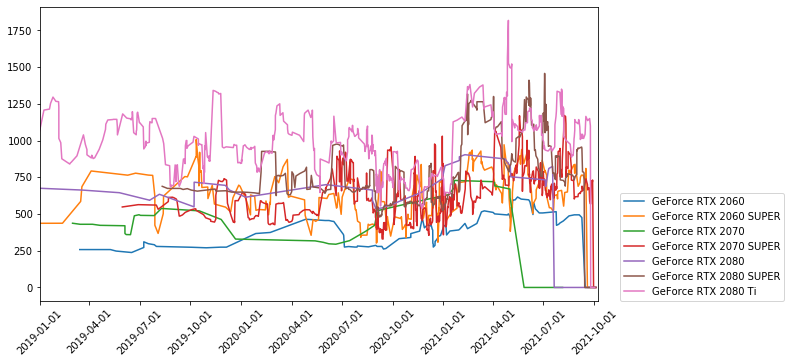

In [110]:
plt.rcParams["figure.figsize"] = [10,6]
plt.subplots_adjust( bottom=0.2 )
plt.xticks( rotation=45 )
ax=plt.gca()
xfmt = md.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis_date()

chipsets = df_found["chipset"].unique()
chipsets.sort()
for chipset in chipsets:
    if " 20" not in chipset:
        continue
        
    d = df_found[df_found["chipset"] == chipset]
    x = d['timestamp']
    x = [datetime.datetime.fromtimestamp(ts) for ts in x]
    
    y = d['prices']
    y = [float(val[0].strip("$").replace(",","")) for val in y]
    y[np.argmax(y)] = 0
    y = moving_average(y,n=7)
    plt.plot(x, y,  label=chipset)
l,r = plt.xlim()
l = md.date2num(datetime.datetime(year=2019, month=1, day=1))
r = md.date2num(datetime.datetime.now() + datetime.timedelta(days=1))

plt.xlim(l,r)
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)
plt.show()

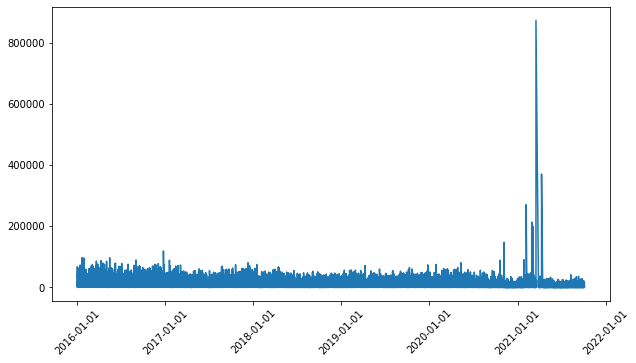

In [88]:
timestamps = np.array(sorted(df_can['timestamp']))
delta = timestamps[1:] - timestamps[:-1]

dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps[:-1]]

plt.subplots_adjust( bottom=0.2 )
plt.xticks( rotation=45 )
ax=plt.gca()
xfmt = md.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates,delta)
plt.show()


In [ ]:
m = np.argmax(delta)
for idx in range(m-3, m+3):
    print(f"{timestamps[idx]}: {delta[idx]:7d}")